<center>
<h1>Notebook for LLM Workshop</h1>
<h2>Tommi Buder-Gröndahl</h2>
<h3>Improvements by Andrea Ferreira</h3>
<h3>Set2024</h3>
</center>

## Part 1. Examining and fine-tuning BERT

Based on a tutorial from [Kaggle](https://www.kaggle.com/code/harshjain123/bert-for-everyone-tutorial-implementation)


In [1]:
# Import Python libraries

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

### Getting BERT and its tokenizer

In [11]:
# Import the Transformers library and download BERT

from transformers import AutoModel, BertTokenizerFast, AdamW

bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


In [12]:
bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [13]:
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

### Defining the BERT-based sentence classifier architecture

In [14]:
##### ANDREA 

class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        
        # Assign the pre-trained BERT model to the class
        self.bert = bert
        
        # First fully connected (dense) layer with input size of 768 (BERT hidden state size) 
        # and output size of 512
        self.fc1 = nn.Linear(768, 512)
        
        # Second fully connected (dense) layer with output size of 2 (for binary classification)
        self.fc2 = nn.Linear(512, 2)
        
        # Dropout layer with a 10% dropout rate to prevent overfitting
        self.dropout = nn.Dropout(0.1)
        
        # ReLU activation function (Rectified Linear Unit) to introduce non-linearity
        self.relu = nn.ReLU()
        
        # LogSoftmax function to convert the output to log probabilities
        # across the two target classes (for binary classification)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        # Pass the inputs to the BERT model and get the output for the [CLS] token
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        
        # Pass the [CLS] output through the first fully connected layer (fc1)
        x = self.fc1(cls_hs)
        
        # Apply the ReLU activation function
        x = self.relu(x)
        
        # Apply dropout to reduce overfitting
        x = self.dropout(x)
        
        # Pass the result through the second fully connected layer (fc2) for the final output
        x = self.fc2(x)
        
        # Apply LogSoftmax to get log probabilities for each class
        return self.softmax(x)

In [15]:
model = BERT_Arch(bert)

In [30]:
# Put model to GPU if available

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [8]:
model

BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

### Getting the dataset

In [16]:
# use pre-labeled spam detection dataset
df = pd.read_csv("/kaggle/input/spamdata-v2/spamdata_v2.csv")
df

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [17]:
##### ANDREA

# Print the number of occurrences for each label
label_counts = df['label'].value_counts()

print("Number of occurrences for each label:")
print(label_counts)


Number of occurrences for each label:
label
0    4825
1     747
Name: count, dtype: int64


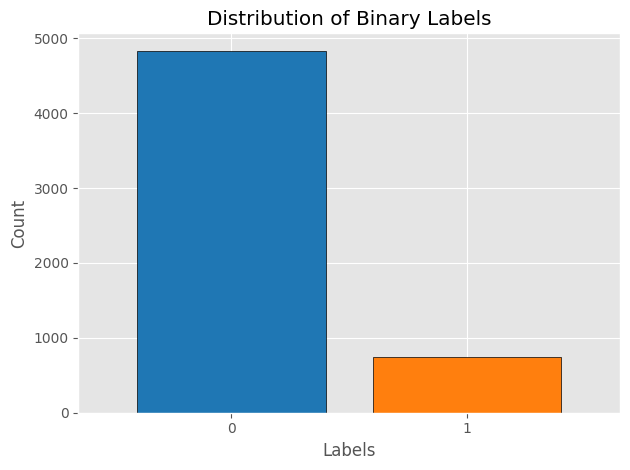

In [29]:
##### ANDREA

# Plot bar chart for label distribution

import matplotlib.pyplot as plt

label_counts = df['label'].value_counts()

colors = ['#1f77b4', '#ff7f0e']  # Blue for 0, Orange for 1

label_counts.plot(kind='bar', color=colors, edgecolor='black', width=0.8)

plt.title('Distribution of Binary Labels')
plt.xlabel('Labels')
plt.ylabel('Count')

# Rotate x-axis labels to horizontal
plt.xticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.show()


In [19]:
##### ANDREA

# Balance the dataset

import pandas as pd
from sklearn.utils import resample

# Split the dataset into two parts based on labels
df_majority = df[df['label'] == 0]  # Majority class (label 0)
df_minority = df[df['label'] == 1]  # Minority class (label 1)

##### Option Undersampling

### Random Undersampling (reduce majority class to the size of the minority class)
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority),  # match minority class
                                   random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
df_balanced_undersample = pd.concat([df_majority_downsampled, df_minority])

# Print the number of occurrences after undersampling
print("After undersampling:")
print(df_balanced_undersample['label'].value_counts())


##### Option Oversampling

### Random Oversampling (increase minority class to the size of the majority class)
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),  # match majority class
                                 random_state=42)  # reproducible results

# Combine majority class with upsampled minority class
df_balanced_oversample = pd.concat([df_majority, df_minority_upsampled])

# Print the number of occurrences after oversampling
print("After oversampling:")
print(df_balanced_oversample['label'].value_counts())


After undersampling:
label
0    747
1    747
Name: count, dtype: int64
After oversampling:
label
0    4825
1    4825
Name: count, dtype: int64


In [20]:
df = df_balanced_undersample  # uncheck this comment for undersampling
# df = df_balanced_oversample  # uncheck this comment for oversampling

In [21]:
##### ANDREA

from sklearn.model_selection import train_test_split

# Function to split and tokenize datasets
def tokenize_texts(texts, tokenizer, max_length=25):
    return tokenizer.batch_encode_plus(
        texts.tolist(),
        max_length=max_length,
        padding='max_length',
        truncation=True
    )

# Split the dataset into train, validation, and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(
    df['text'], df['label'], 
    random_state=2024, 
    test_size=0.3, 
    stratify=df['label']
)

val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text, temp_labels, 
    random_state=2024, 
    test_size=0.5, 
    stratify=temp_labels
)

# Tokenize and encode sequences
tokens_train = tokenize_texts(train_text, tokenizer)
tokens_val = tokenize_texts(val_text, tokenizer)
tokens_test = tokenize_texts(test_text, tokenizer)


In [22]:
# convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [23]:
# train_mask is used for ignoring input padding in attention

print(tokenizer.decode(train_seq[0]))
print(train_mask[0])

[CLS] gent! we are trying to contact you. last weekends draw shows that you won a a£1000 prize [SEP]
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1])


### Training the classifier

In [24]:
# define a batch size
batch_size = 32

# wrap tensors for training data
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for randomly sampling data during training
train_sampler = RandomSampler(train_data)

# dataLoader for training data
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors for validation data
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for randomly sampling data during validation
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [25]:
# freeze all BERT parameters (training only linear layers outside of BERT)
for param in bert.parameters():
    param.requires_grad = False

In [31]:
# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5) 

#compute the class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [26]:
##### ANDREA

# Function to train the model
def train():
    # Set the model to training mode (this activates Dropout layers)
    model.train()

    # Initialize total loss and accuracy for tracking progress
    total_loss, total_accuracy = 0, 0
    total_preds = []  # To store model predictions

    # Loop through each batch of data in the training set
    for step, batch in enumerate(train_dataloader):
        
        # Print progress every 50 batches
        if step % 50 == 0 and step != 0:
            print(f'  Batch {step} of {len(train_dataloader)}.')

        # Move the batch to the device (GPU or CPU)
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        # Reset any previously calculated gradients
        model.zero_grad()

        # Make predictions for this batch of data
        preds = model(sent_id, mask)

        # Calculate the loss (difference between actual and predicted labels)
        loss = cross_entropy(preds, labels)

        # Add this batch's loss to the total loss
        total_loss += loss.item()

        # Backpropagation: Calculate the gradients
        loss.backward()

        # Clip gradients to prevent them from getting too large (helps stability)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update the model parameters based on the calculated gradients
        optimizer.step()

        # Move predictions to the CPU and store them
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)

        # Calculate accuracy for this batch
        preds_flat = np.argmax(preds, axis=1)
        labels_flat = labels.cpu().numpy()
        batch_accuracy = np.sum(preds_flat == labels_flat) / len(labels_flat)
        total_accuracy += batch_accuracy

    # Calculate the average loss and accuracy for the entire epoch
    avg_loss = total_loss / len(train_dataloader)
    avg_accuracy = total_accuracy / len(train_dataloader) ##*** IT WAS MISSING

    # Concatenate all predictions into one array
    total_preds = np.concatenate(total_preds, axis=0)

    # Return the average loss, average accuracy, and all the predictions
    return avg_loss, avg_accuracy, total_preds


In [27]:
##### ANDREA
    
# Function for evaluating the model
def evaluate():
    
    print("\nEvaluating...")
  
    # Set the model to evaluation mode (deactivates Dropout layers)
    model.eval()

    # Initialize total loss and accuracy
    total_loss, total_accuracy = 0, 0
    
    # Empty list to save the model predictions
    total_preds = []

    # Iterate over batches in the validation set
    for step, batch in enumerate(val_dataloader):
        
        # Progress update every 50 batches
        if step % 50 == 0 and step != 0:
            print(f'  Batch {step} of {len(val_dataloader)}.')

        # Move the batch to the device (GPU or CPU)
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        # Deactivate autograd (no gradient calculation)
        with torch.no_grad():
            
            # Model predictions for the current batch
            preds = model(sent_id, mask)

            # Compute the validation loss
            loss = cross_entropy(preds, labels)

            # Add the batch loss to the total loss
            total_loss += loss.item()

            # Move predictions to the CPU
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

            # Calculate accuracy for this batch
            preds_flat = np.argmax(preds, axis=1)
            labels_flat = labels.cpu().numpy()
            batch_accuracy = np.sum(preds_flat == labels_flat) / len(labels_flat)
            total_accuracy += batch_accuracy

    # Compute the average loss and accuracy for the entire validation set
    avg_loss = total_loss / len(val_dataloader)
    avg_accuracy = total_accuracy / len(val_dataloader)

    # Concatenate all predictions into one array
    total_preds = np.concatenate(total_preds, axis=0)

    # Return the average loss, average accuracy, and predictions
    return avg_loss, avg_accuracy, total_preds


In [33]:
##### ANDREA

# Set initial best validation loss to infinite
best_valid_loss = float('inf')

# Lists to store training and validation losses and accuracies for each epoch
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

# Number of epochs to train the model
for epoch in range(epochs):
    
    print(f'\n Epoch {epoch + 1} / {epochs}')
    
    # Train the model and get the training loss and accuracy
    train_loss, train_accuracy, _ = train()
    
    # Evaluate the model and get the validation loss and accuracy
    valid_loss, valid_accuracy, _ = evaluate()
    
    # Save the best model if the validation loss decreases
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/kaggle/working/saved_weights.pt')
    
    # Append training and validation loss and accuracy to their respective lists
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)
    
    # Print training and validation results for this epoch
    print(f'\nTraining Loss: {train_loss:.3f} | Training Accuracy: {train_accuracy:.3f}')
    print(f'Validation Loss: {valid_loss:.3f} | Validation Accuracy: {valid_accuracy:.3f}')

# Load the best model (with the lowest validation loss) for testing
path = '/kaggle/working/saved_weights.pt'
model.load_state_dict(torch.load(path))

# Evaluate the model on the test set
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

# Convert the predictions to label indices
preds = np.argmax(preds, axis=1)

# Print the classification report for the test set
print(classification_report(test_y, preds))

# Free GPU memory (optional)
if torch.cuda.is_available():
    torch.cuda.empty_cache()



 Epoch 1 / 10

Evaluating...

Training Loss: 0.592 | Training Accuracy: 0.746
Validation Loss: 0.579 | Validation Accuracy: 0.826

 Epoch 2 / 10

Evaluating...

Training Loss: 0.586 | Training Accuracy: 0.775
Validation Loss: 0.571 | Validation Accuracy: 0.830

 Epoch 3 / 10

Evaluating...

Training Loss: 0.574 | Training Accuracy: 0.764
Validation Loss: 0.562 | Validation Accuracy: 0.839

 Epoch 4 / 10

Evaluating...

Training Loss: 0.569 | Training Accuracy: 0.792
Validation Loss: 0.555 | Validation Accuracy: 0.830

 Epoch 5 / 10

Evaluating...

Training Loss: 0.561 | Training Accuracy: 0.778
Validation Loss: 0.547 | Validation Accuracy: 0.839

 Epoch 6 / 10

Evaluating...

Training Loss: 0.549 | Training Accuracy: 0.781
Validation Loss: 0.539 | Validation Accuracy: 0.844

 Epoch 7 / 10

Evaluating...

Training Loss: 0.546 | Training Accuracy: 0.796
Validation Loss: 0.532 | Validation Accuracy: 0.839

 Epoch 8 / 10

Evaluating...

Training Loss: 0.545 | Training Accuracy: 0.792
Vali

In [34]:
## loading saved model

import torch

saved_model_path = '/kaggle/input/saved_weights.pt/transformers/default/1/saved_weights.pt'
model = torch.load(saved_model_path)


## Part 2. Sentence similarities with SentenceBERT

Based on [SentenceBERT documentation](https://sbert.net/)

In [55]:
# !pip install sentence-transformers


In [56]:
from sentence_transformers import SentenceTransformer


In [57]:
model = SentenceTransformer("all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [58]:
# sentences to encode
sentences = [
    "I am happy.",
    "I am sad.",
    "I am content.",
    "I am not happy.",
    "I am not sad."
]

# embeddings
embeddings = model.encode(sentences)

# embedding similarities
similarities = model.similarity(embeddings, embeddings)
print(similarities)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

tensor([[1.0000, 0.4128, 0.5024, 0.7230, 0.4712],
        [0.4128, 1.0000, 0.3096, 0.4911, 0.7424],
        [0.5024, 0.3096, 1.0000, 0.4433, 0.3470],
        [0.7230, 0.4911, 0.4433, 1.0000, 0.6147],
        [0.4712, 0.7424, 0.3470, 0.6147, 1.0000]])


## Part 3. Examining Llama2 predictions

In [4]:
# !pip install -U bitsandbytes

## after installing it, you may need to 'stop session' and run it again from here

In [3]:
import bitsandbytes as bnb
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

In [5]:
compute_dtype = getattr(torch, "float16")
quant_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=compute_dtype, bnb_4bit_use_double_quant=False)

# Pre-trained LLAMA2 from Hugging Face hub
base_model = "NousResearch/Llama-2-7b-chat-hf"

model = AutoModelForCausalLM.from_pretrained(base_model, quantization_config=quant_config, device_map={"": 0})
model.config.use_cache = False
model.config.pretraining_tp = 1

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

In [6]:
# examining model structure
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNor

In [7]:
# generating text with a prompt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

prompt = "Who is Ferdinand de Saussure?"
inputs = tokenizer(prompt, return_tensors="pt")

generate_ids = model.generate(inputs.input_ids.to(device), max_length=100)
output = tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

print(output)

Who is Ferdinand de Saussure?
 everybody who has studied linguistics knows that the father of modern linguistics is Ferdinand de Saussure. He was a Swiss linguist who lived from 1857 to 1913. Saussure is considered the founder of modern linguistics because he laid the groundwork for the field as we know it today.

Saussure's most important work is his book "Course in General Linguistics,"


### Getting probabilities for the next word

Based on [this Reddit thread](https://www.reddit.com/r/LocalLLaMA/comments/1b6xbg9/displayingreturning_probabilitieslogprobs_of_next/?rdt=37394)

In [9]:
input_string = "I am"

# tokenize input
input_ids = tokenizer.encode(input_string, return_tensors="pt")

# get model predictions (logits: values before they are turned into probabilities via softmax)
logits = model(input_ids).logits

# last projection: predicted next word after input
logits = logits[-1, -1]

# change logits to probabilities via softmax
probs = torch.nn.functional.softmax(logits, dim=-1)

# top 10 most probable predicted words
probs, ids = torch.topk(probs, 10)

# convert token ids to text tokens
texts = tokenizer.convert_ids_to_tokens(ids)

# print probabilities + tokens
for prob, text in zip(probs, texts):
    print(f"{prob:.4f}: \"{text}\"")

0.2253: "▁a"
0.0631: "▁pleased"
0.0531: "▁not"
0.0503: "▁so"
0.0454: "▁thr"
0.0420: "▁an"
0.0315: "▁writing"
0.0255: "▁excited"
0.0203: "▁grateful"
0.0183: "▁happy"


### Getting predictions from different Llama2 layers

Based on this [code](https://github.com/nrimsky/LM-exp/blob/main/intermediate_decoding/intermediate_decoding.ipynb) with an associated [post](https://www.lesswrong.com/posts/fJE6tscjGRPnK8C2C/decoding-intermediate-activations-in-llama-2-7b)

In [10]:
class AttnWrapper(torch.nn.Module):
    def __init__(self, attn):
        super().__init__()
        self.attn = attn
        self.activations = None
        self.add_tensor = None

    def forward(self, *args, **kwargs):
        output = self.attn(*args, **kwargs)
        if self.add_tensor is not None:
            output = (output[0] + self.add_tensor,)+output[1:]
        self.activations = output[0]
        return output

    def reset(self):
        self.activations = None
        self.add_tensor = None


class BlockOutputWrapper(torch.nn.Module):
    def __init__(self, block, unembed_matrix, norm):
        super().__init__()
        self.block = block
        self.unembed_matrix = unembed_matrix
        self.norm = norm

        self.block.self_attn = AttnWrapper(self.block.self_attn)
        self.post_attention_layernorm = self.block.post_attention_layernorm

        self.attn_mech_output_unembedded = None
        self.intermediate_res_unembedded = None
        self.mlp_output_unembedded = None
        self.block_output_unembedded = None

    def forward(self, *args, **kwargs):
        output = self.block(*args, **kwargs)
        self.block_output_unembedded = self.unembed_matrix(self.norm(output[0]))
        attn_output = self.block.self_attn.activations
        self.attn_mech_output_unembedded = self.unembed_matrix(self.norm(attn_output))
        attn_output += args[0]
        self.intermediate_res_unembedded = self.unembed_matrix(self.norm(attn_output))
        mlp_output = self.block.mlp(self.post_attention_layernorm(attn_output))
        self.mlp_output_unembedded = self.unembed_matrix(self.norm(mlp_output))
        return output

    def attn_add_tensor(self, tensor):
        self.block.self_attn.add_tensor = tensor

    def reset(self):
        self.block.self_attn.reset()

    def get_attn_activations(self):
        return self.block.self_attn.activations


class Llama7BHelper:
    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.tokenizer = tokenizer
        self.model = model
        for i, layer in enumerate(self.model.model.layers):
            self.model.model.layers[i] = BlockOutputWrapper(layer, self.model.lm_head, self.model.model.norm)

    def generate_text(self, prompt, max_length=100):
        inputs = self.tokenizer(prompt, return_tensors="pt")
        generate_ids = self.model.generate(inputs.input_ids.to(self.device), max_length=max_length)
        return self.tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

    def get_logits(self, prompt):
        inputs = self.tokenizer(prompt, return_tensors="pt")
        with torch.no_grad():
          logits = self.model(inputs.input_ids.to(self.device)).logits
          return logits

    def set_add_attn_output(self, layer, add_output):
        self.model.model.layers[layer].attn_add_tensor(add_output)

    def get_attn_activations(self, layer):
        return self.model.model.layers[layer].get_attn_activations()

    def reset_all(self):
        for layer in self.model.model.layers:
            layer.reset()
            
    def print_decoded_activations(self, decoded_activations, label, topk=10):
        softmaxed = torch.nn.functional.softmax(decoded_activations[0][-1], dim=-1)
        values, indices = torch.topk(softmaxed, topk)
        probs_percent = [int(v * 100) for v in values.tolist()]
        tokens = self.tokenizer.batch_decode(indices.unsqueeze(-1))
        print(label, list(zip(tokens, probs_percent)))

    def decode_all_layers(self, text, topk=10, print_attn_mech=True, print_intermediate_res=True, print_mlp=True, print_block=True):
        self.get_logits(text)
        for i, layer in enumerate(self.model.model.layers):
            print(f'Layer {i}: Decoded intermediate outputs')
            if print_attn_mech:
                self.print_decoded_activations(layer.attn_mech_output_unembedded, 'Attention mechanism', topk=topk)
            if print_intermediate_res:
                self.print_decoded_activations(layer.intermediate_res_unembedded, 'Intermediate residual stream', topk=topk)
            if print_mlp:
                self.print_decoded_activations(layer.mlp_output_unembedded, 'MLP output', topk=topk)
            if print_block:
                self.print_decoded_activations(layer.block_output_unembedded, 'Block output', topk=topk)
            print()

In [11]:
helper = Llama7BHelper()

In [12]:
helper.decode_all_layers('Colorless green')

Layer 0: Decoded intermediate outputs
Attention mechanism [('solution', 0), ('loose', 0), ('berga', 0), ('', 0), ('first', 0), ('Private', 0), ('itself', 0), ('applied', 0), ('h', 0), ('пута', 0)]
Intermediate residual stream [('ery', 8), ('berga', 2), ('ো', 0), ('Fritz', 0), ('SM', 0), ('SM', 0), ('solution', 0), ('aram', 0), ('hill', 0), ('ći', 0)]
MLP output [('Kontrola', 2), ('昌', 0), ('Sito', 0), ('崎', 0), ('пута', 0), ('prüfe', 0), ('阳', 0), ('乡', 0), ('mez', 0), ('bezeichneter', 0)]
Block output [('ery', 6), ('berga', 0), ('пута', 0), ('昌', 0), ('ো', 0), ('mez', 0), ('Apple', 0), ('阳', 0), ('Kontrola', 0), ('Ě', 0)]

Layer 1: Decoded intermediate outputs
Attention mechanism [('références', 1), ('chev', 0), ('isz', 0), ('rot', 0), ('embar', 0), ('Насе', 0), ('imedia', 0), ('ˇ', 0), ('older', 0), ('réseau', 0)]
Intermediate residual stream [('ery', 20), ('print', 1), ('Außer', 1), ('wich', 0), ('mez', 0), ('mark', 0), ('ija', 0), ('dear', 0), ('impression', 0), ('lá', 0)]
MLP outp